In [18]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import seaborn as sns
import torchvision.transforms as transforms
import torchvision.datasets as dsets
from sklearn.metrics import classification_report, confusion_matrix, precision_score,recall_score,f1_score, roc_curve, roc_auc_score, matthews_corrcoef
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import torch_directml

In [6]:
dml = torch_directml.device()
dml

device(type='privateuseone', index=0)

In [8]:
test_and_val_transform = transforms.Compose([
        # transforms.ToPILImage(),
        transforms.Grayscale(),
        transforms.Resize(size = (224, 224)),
        transforms.ToTensor(),
        #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

In [9]:
dataset_path = "../splitted"
test_dataset = dsets.ImageFolder(root=f'{dataset_path}/test/', transform=test_and_val_transform)

In [10]:
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=8, drop_last=True, shuffle=False)

In [11]:
class MyCNN1(nn.Module):
    def __init__(self):
        super(MyCNN1, self).__init__()
        self.cnn_layer_1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=(3, 3), stride=1, padding=0, bias=False)
        self.batch_norm_1 = nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.maxpool_1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=0)
        
        self.cnn_layer_2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), stride=1, padding=0, bias=False)
        self.batch_norm_2 = nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.maxpool_2 = nn.MaxPool2d(kernel_size=3, stride=2, padding=0)
        
        self.cnn_layer_3 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(3, 3), stride=1, padding=0, bias=False)
        self.batch_norm_3 = nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.maxpool_3 = nn.MaxPool2d(kernel_size=3, stride=2, padding=0)


        self.flatten = nn.Flatten()
        self.relu = nn.ReLU()
        self.linear_layer_1 = nn.Linear(256*25*25, 2)
                                        
                        
    
    def forward(self, x):
        x = self.cnn_layer_1(x)
        x = self.batch_norm_1(x)
        x = self.relu(x)
        x = self.maxpool_1(x)


        x = self.cnn_layer_2(x)
        x = self.batch_norm_2(x)
        x = self.relu(x)
        x = self.maxpool_2(x)

        x = self.cnn_layer_3(x)
        x = self.batch_norm_3(x)
        x = self.relu(x)
        x = self.maxpool_3(x)
        
#         print(x.shape)

        x = self.flatten(x)

        x = self.linear_layer_1(x)
        
        return x

In [12]:
base_model = MyCNN1().to(dml)
base_model

MyCNN1(
  (cnn_layer_1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (batch_norm_1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool_1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn_layer_2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (batch_norm_2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool_2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn_layer_3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (batch_norm_3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool_3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (relu): ReLU()
  (linear_layer_1): Linear(in_features=160000, out_features=2, bias=True)
)

In [13]:
model_path = "../trained-models/mycnn.pt"
base_model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [14]:
def get_predictions():
    softmax = nn.Softmax(dim=1)
    base_model.eval()
    predictions = []
    real_values = []
    pred_probas = []
    misclassified = []
    
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(dml)
            labels = labels.to(dml)
            
            outputs = softmax(base_model(images))
            
            _, preds = torch.max(outputs, dim = 1)
            for probs in outputs.cpu():   
                pred_probas.append(list(probs))
            preds = preds.cpu()
            labels = labels.cpu()
            predictions.extend(preds)
            real_values.extend(labels)
            
            for ind, (actual, pred) in enumerate(zip(labels, preds)):
                if actual != pred:
                    img = images[ind].cpu()
                    misclassified.append((np.array(img), actual, pred))
            
    return predictions, real_values, pred_probas, misclassified

In [15]:
pred, real, probas, misclassified = get_predictions()
print(classification_report([y_actual.item() for y_actual in real], [y_pred.item() for y_pred in pred], digits=4))

              precision    recall  f1-score   support

           0     0.8189    0.8510    0.8346      4926
           1     0.8448    0.8117    0.8279      4922

    accuracy                         0.8313      9848
   macro avg     0.8318    0.8313    0.8313      9848
weighted avg     0.8318    0.8313    0.8313      9848



In [19]:
class_name = [0, 1]
def score_in_details():
  y_pred = [y.item() for y in pred]
  y_real = [y.item() for y in real]
    
  temp = []
  for i in probas:
    temp1 = []
    for j in i:
        temp1.append(j.item())
    temp.append(temp1)

  accuracy = recall_score(y_real, y_pred, average='macro')
  precision = precision_score(y_real, y_pred, average='macro')
  recall = recall_score(y_real, y_pred, average='macro')
  f1 = f1_score(y_real, y_pred, average='macro')
#   roc_auc = roc_auc_score(y_real, temp)
  mcc_score = matthews_corrcoef(y_real, y_pred);

  print(f"Accuracy: {accuracy * 100}%")
  print(f"Precision: {precision * 100}%")
  print(f"Recall: {recall * 100}%")
  print(f"F1-score: {f1 * 100}%")
  print(f"MCC-score: {mcc_score * 100}%")
#   print(f"ROC AUC score: {roc_auc}")
  
  print()
  print()

  conf_matrix = confusion_matrix(y_real, y_pred)
  fig, ax = plt.subplots(figsize=(5,5))
  sns.heatmap(pd.DataFrame(conf_matrix), annot = True, cmap = 'YlGnBu',fmt = 'g', xticklabels=class_name, yticklabels=class_name)
  plt.title('Confusion matrix', fontsize=10)
  plt.ylabel('Actual label', fontsize=10)
  plt.xlabel('Predicted label', fontsize=10)
  plt.show()

Accuracy: 83.13283239651021%
Precision: 83.18487124227278%
Recall: 83.13283239651021%
F1-score: 83.12687920418628%
MCC-score: 66.31768322159618%




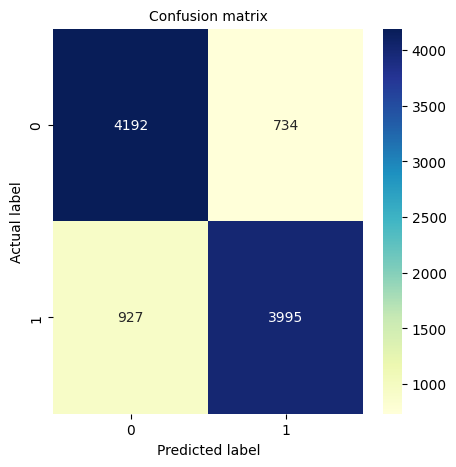

In [20]:
score_in_details()